# Examples of pyqrse

### imports

In [1]:
# %load imports.py
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

from pandas import Series, DataFrame
from tabulate import tabulate
from IPython.display import Latex 
from tqdm import tqdm
from importlib import reload
from collections import defaultdict

import copy
import csv
import datetime
import time
import os

print(os.getcwd())
os.chdir("..")

import pyqrse
from pyqrse import QRSE
from pyqrse.utilities.helpers import mprint

/Users/keithblackwell1/Documents/GoogStudy/py3qrse/example


## Load Data, Fit, Sample

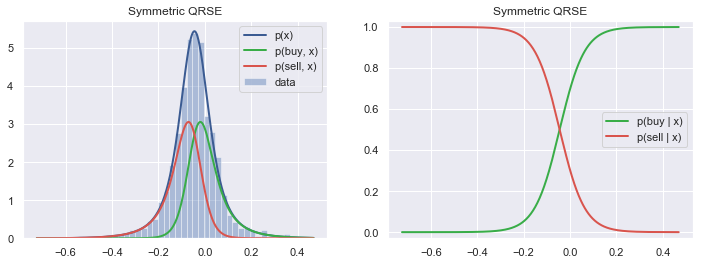

In [2]:
qrse = QRSE('S', data = './example/data2.csv')
qrse.fit()
qrse.plotboth(bins=40)

estimation results

In [3]:
qrse.res

      fun: -1242.2189200679056
 hess_inv: array([[ 2.34984255e-05,  7.94285094e-04, -5.63780071e-07],
       [ 7.94285094e-04,  1.57243210e-01, -2.54498486e-05],
       [-5.63780071e-07, -2.54498486e-05,  5.18946251e-06]])
      jac: array([-2.31596823e-06,  7.18506072e-08,  2.95045623e-06])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 12
     njev: 15
   status: 0
  success: True
        x: array([ 0.05369041, 11.00799368, -0.04473894])

Initialize sampler

In [4]:
qrse.set_hess_inv()
qrse.sampler.init()
qrse.sampler.mcmc(20000)

  1%|          | 161/20000 [00:00<00:12, 1609.93it/s]

hess is pos def? : True


100%|██████████| 20000/20000 [00:11<00:00, 1668.79it/s]

[0.4554 0.     0.    ]


View sampler results

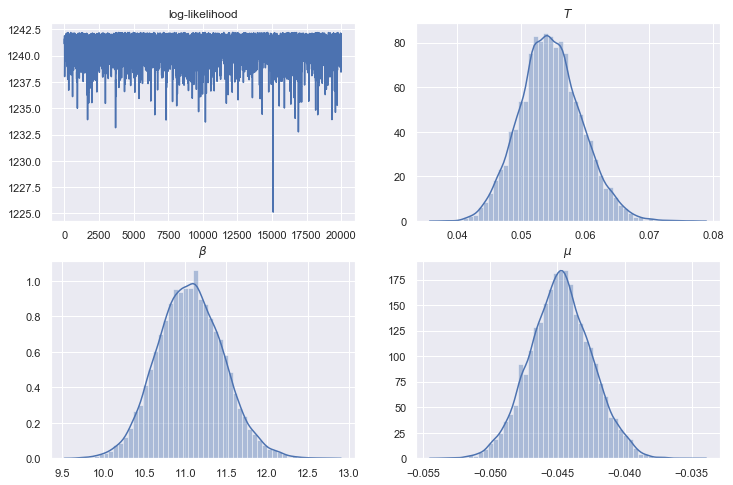

In [5]:
qrse.sampler.plot()

## There are a lot of QRSE Kernels

In [12]:
pyqrse.available_kernels()

 code    n_actions           class                long_name      
------------------------------------------------------------
  S    |     2      |   SQRSEKernel    |  Symmetric QRSE 
  AA   |     3      |   AAQRSEKernel   | Asymmetric-Action QRSE
 SNH   |     2      |  SQRSEKernelNoH  | Symmetric QRSE (No Entropy)
  SF   |     2      |   SFQRSEKernel   | Scharfenaker and Foley QRSE
 AAX   |     3      |  AAXQRSEKernel   | Asymmetric-Action(xi) QRSE
  AT   |     3      |   ATQRSEKernel   | Asymmetric-Temperature QRSE
  AX   |     3      |   AXQRSEKernel   | Asymmetric (xi) QRSE
 SFC   |     2      |  SFCQRSEKernel   | Scharfenaker and Foley QRSE (Centered)
 ABX   |     2      |  ABXQRSEKernel   | Asymmetric-Beta (xi) QRSE
ABXNH  |     2      | ABXQRSEKernelNH  | Asymmetric-Beta QRSE (Xi, No Entropy)
  A    |     3      |   AQRSEKernel    | Asymmetric QRSE 
 ABXC  |     2      |  ABXCQRSEKernel  | Asymmetric-Beta QRSE (Xi, Centered)
  AB   |     2      |   ABQRSEKernel   | Asymmetric-B

Estimate Multiple Models on the same data

In [13]:
codes = ['S', 'SF',  'AB', 'AA', 'AT', 'A']

print('QRSEModels in models and model_hash:\n')
models = []

for i, code in enumerate(codes):
    
    model = pyqrse.QRSE(code, data='./example/data2.csv')
    model.fit()
    models.append(model)
    print("{}. {}".format(i+1, model.long_name))

model_hash = dict(zip(codes, models))  

QRSEModels in models and model_hash:

1. Symmetric QRSE
2. Scharfenaker and Foley QRSE
3. Asymmetric-Beta QRSE
4. Asymmetric-Action QRSE
5. Asymmetric-Temperature QRSE
6. Asymmetric QRSE


Compare model selection criteria

In [14]:
body = [['name', 'nll', 'aic', 'aicc', 'bic', 'success?']]
for model in models: 
    body.append([model.name, model.res.fun, model.aic(), 
                 model.aicc(), model.bic(), 
                 str(model.res.success)])
    
mprint(body, rb="-")

|  name   |   nll    |   aic    |   aicc   |   bic    | success? |
------------------------------------------------------------------
| S-QRSE  | -1242.22 | -2478.44 | -2478.42 | -2462.85 |   True   |
------------------------------------------------------------------
| SF-QRSE | -1243.87 | -2477.74 | -2477.70 | -2451.77 |   True   |
------------------------------------------------------------------
| AB-QRSE | -1243.94 | -2479.88 | -2479.85 | -2459.10 |  False   |
------------------------------------------------------------------
| AA-QRSE | -1243.84 | -2477.68 | -2477.63 | -2451.71 |  False   |
------------------------------------------------------------------
| AT-QRSE | -1242.53 | -2477.07 | -2477.04 | -2456.29 |   True   |
------------------------------------------------------------------
| A-QRSE  | -1243.94 | -2475.88 | -2475.82 | -2444.71 |  False   |
------------------------------------------------------------------



Compare parameter estimates

In [15]:
for model in models:
    print('\n', "{:9}".format(model.name), "*-"*20)
    print(("{: ^8}"*model.fn_params).format(*model.fpnames))
    print(("{: .4f} "*model.fn_params).format(*model.fparams))


 S-QRSE    *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
   t       b       m    
 0.0537  11.0080 -0.0447 

 SF-QRSE   *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
   t       b       m       g       xi   
 0.0540  11.0752 -0.0350  0.5077 -0.0479 

 AB-QRSE   *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
   t     b_buy     m     b_sell 
 0.0540  10.2620 -0.0390  11.9371 

 AA-QRSE   *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
 t_buy   t_sell  m_buy   m_sell    b    
 0.0539  18602163.8907 -0.1756  47370002.7838  11.4838 

 AT-QRSE   *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
 t_buy   t_sell    m       b    
 0.0657  0.0935 -0.0408  10.2281 

 A-QRSE    *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
 t_buy   t_sell  m_buy   m_sell  b_buy   b_sell 
 0.1153  0.1017 -2.5451  2.1721  11.9371  10.2620 


Compare Fits of all data

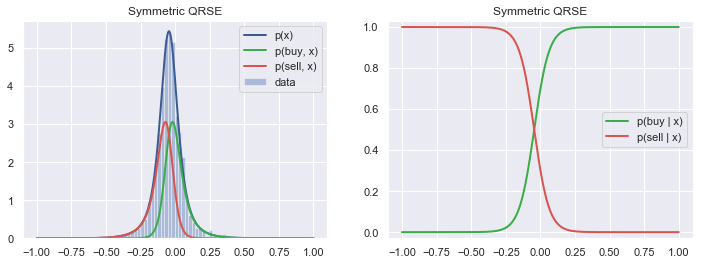

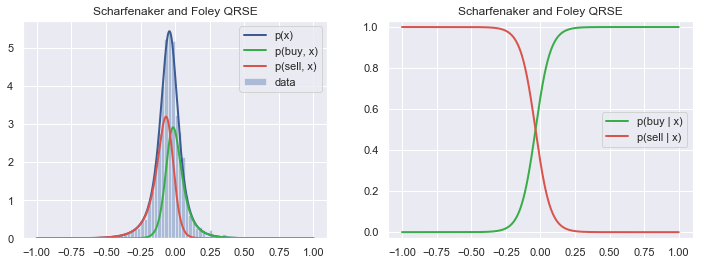

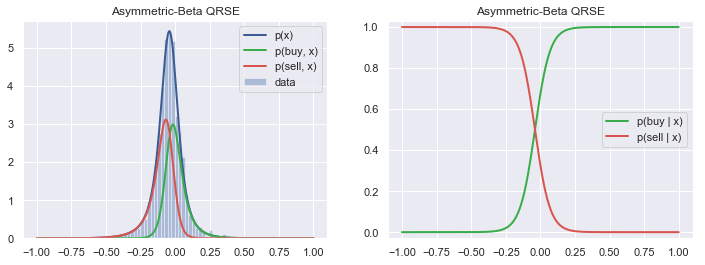

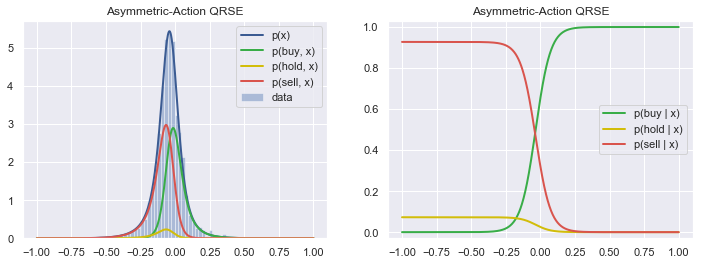

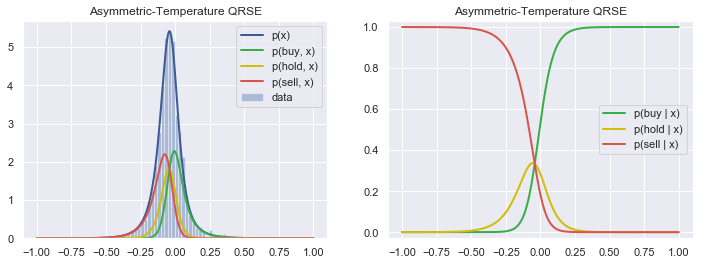

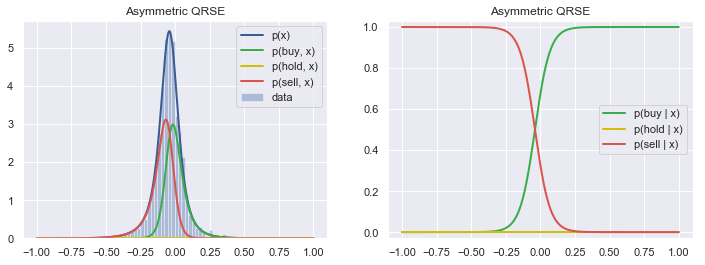

In [25]:
for i, model in enumerate(models):
    model.plotboth(bounds=(-1, 1), bins=40)